#SCENARIO: Base de Datos: myMovieStore  en RDS

ESte archivo contiene los pasos necesarios para realizar la base de datos en RDS- AWS.  Tomar en cuenta que se usarán varios archivos.

Los siguientes archivos son subidos al espacio de Google-Colab para que pueda esto pueda funcionar:

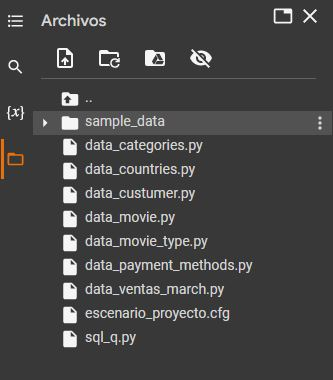

#Importamos las librerias

Intalamos las librerias necesarias para conectar con AWS.

In [4]:
!pip install boto3
!pip install psycopg2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import pandas as pd
import numpy as np
import random
import datetime
import boto3
import psycopg2
import configparser

In [12]:
rdsIdentifier = 'myMoviestore' #nombre de la instancia
 #inicialización para creación de data rando

###Archivo de configuración

In [13]:
config = configparser.ConfigParser()
config.read('/content/escenario_proyecto.cfg')

['/content/escenario_proyecto.cfg']

###Creamos instancia en AWS

In [14]:
aws_conn = boto3.client('rds', aws_access_key_id=config.get('IAM', 'ACCESS_KEY'),
                    aws_secret_access_key=config.get('IAM', 'SECRET_ACCESS_KEY'),
                    region_name='us-east-2')

###Checkear instancias disponibles

In [15]:
rdsInstanceIds = []

response = aws_conn.describe_db_instances()
for resp in response['DBInstances']:
    rdsInstanceIds.append(resp['DBInstanceIdentifier'])
    db_instance_status = resp['DBInstanceStatus']

print(f"DBInstanceIds {rdsInstanceIds}")

DBInstanceIds ['banco-db']


###Creamos instancia si no existe



El siguiente código crea la base de datos si no existe.

In [16]:
try:
    response = aws_conn.create_db_instance(
            AllocatedStorage=10,
            DBName=config.get('RDS', 'DB_NAME'),
            DBInstanceIdentifier=rdsIdentifier,
            DBInstanceClass="db.t3.micro",
            Engine="postgres",
            MasterUsername=config.get('RDS', 'DB_USER'),
            MasterUserPassword=config.get('RDS', 'DB_PASSWORD'),
            Port=int(config.get('RDS', 'DB_PORT')),
            VpcSecurityGroupIds=[config.get('VPC', 'SECURITY_GROUP')],
            PubliclyAccessible=True
        )
    print(response)
except aws_conn.exceptions.DBInstanceAlreadyExistsFault as ex:
    print("La Instancia de Base de Datos ya Existe.")

{'DBInstance': {'DBInstanceIdentifier': 'mymoviestore', 'DBInstanceClass': 'db.t3.micro', 'Engine': 'postgres', 'DBInstanceStatus': 'creating', 'MasterUsername': 'myAdmin', 'DBName': 'myMoviestore', 'AllocatedStorage': 10, 'PreferredBackupWindow': '08:46-09:16', 'BackupRetentionPeriod': 1, 'DBSecurityGroups': [], 'VpcSecurityGroups': [{'VpcSecurityGroupId': 'sg-0cb3229fb3dd642cb', 'Status': 'active'}], 'DBParameterGroups': [{'DBParameterGroupName': 'default.postgres14', 'ParameterApplyStatus': 'in-sync'}], 'DBSubnetGroup': {'DBSubnetGroupName': 'default', 'DBSubnetGroupDescription': 'default', 'VpcId': 'vpc-094e3b8ab6df21ac8', 'SubnetGroupStatus': 'Complete', 'Subnets': [{'SubnetIdentifier': 'subnet-0c1e93e194fef40ca', 'SubnetAvailabilityZone': {'Name': 'us-east-2b'}, 'SubnetOutpost': {}, 'SubnetStatus': 'Active'}, {'SubnetIdentifier': 'subnet-029aee6569dca7877', 'SubnetAvailabilityZone': {'Name': 'us-east-2a'}, 'SubnetOutpost': {}, 'SubnetStatus': 'Active'}, {'SubnetIdentifier': 'subn

Al ejecutar la celda anterior, se creará una instancia en RDS-AWS. Esperamos alrededor de 5 minutos mientras se crea en AWS -RDS.

###Obtenemos el End-Point de la Instancia

In [17]:
try:
     instances = aws_conn.describe_db_instances(DBInstanceIdentifier=rdsIdentifier)
     RDS_HOST = instances.get('DBInstances')[0].get('Endpoint').get('Address')
     print(RDS_HOST)
except Exception as ex:
     print("La instancia de base de datos no existe o aun no se ha terminado de crear.")
     print(ex)

mymoviestore.c6j34omip28z.us-east-2.rds.amazonaws.com


###Creamos las tablas

Antes de crear las tablas, es necesario importar el archivo que crea las tablas sql_queries.py:

In [33]:
import sql_q

try:
    db_conn = psycopg2.connect(
        database=config.get('RDS', 'DB_NAME'), 
        user=config.get('RDS', 'DB_USER'),
        password=config.get('RDS', 'DB_PASSWORD'), 
        host=RDS_HOST,
        port=config.get('RDS', 'DB_PORT')
    )

    cursor = db_conn.cursor()
    cursor.execute(sql_q.DDL_QUERY)
    db_conn.commit()
    print("Base de Datos Creada Exitosamente")
except Exception as ex:
    print("ERROR: Error al crear la base de datos.")
    print(ex)

Base de Datos Creada Exitosamente


#Insertamos Datos

Declaramos la función para insertar los Datos a la base de Datos.

###Función para insertar los datos.

In [34]:
def insertDataToSQL(data_dict, table_name):
     postgres_driver = f"""postgresql://{config.get('RDS', 'DB_USER')}:{config.get('RDS', 'DB_PASSWORD')}@{RDS_HOST}:{config.get('RDS', 'DB_PORT')}/{config.get('RDS', 'DB_NAME')}"""    
     df_data = pd.DataFrame.from_records(data_dict)
     try:
          response = df_data.to_sql(table_name, postgres_driver, index=False, if_exists='append')
          print(f'Se han insertado {response} nuevos registros.' )
     except Exception as ex:
          print(ex)

###Insertando los Clientes

Importamos los datos guardados en diccionarios en un archivo de Python. El archivo con los datos de los clientes actuales se llama data_custumer:

In [40]:
import data_custumer
data_clientes = data_custumer.cliente

#insertamos data en tabla de los custumer
insertDataToSQL(data_clientes, 'custumer')

Se han insertado 300 nuevos registros.


###Insertando los Paises

Primero importamos la lista de diccionarios del archivo de datos de python de nuestros paises.

In [41]:
import data_countries
countries = data_countries.countries

#insertamos data en tabla de los countries
insertDataToSQL(countries, 'countries')

Se han insertado 101 nuevos registros.


###Insertando Categories

Primero importamos la lista de diccionarios del archivo de datos de python de las categorias de peliculas y luego los insertamos.

In [42]:
import data_categories
categories = data_categories.category

#insertamos data en tabla de los countries
insertDataToSQL(categories, 'categories')

Se han insertado 35 nuevos registros.


###Insertando Movie Types

Importamos la lista de diccionarios del archivo de datos de python de los movie types y luego los insertamos.

In [43]:
import data_movie_type
movie_type = data_movie_type.movie_type

#insertamos data en tabla de las movie_type
insertDataToSQL(movie_type, 'movie_type')

Se han insertado 2 nuevos registros.


###Insertando el catálogo de peliculas

Importamos el catálogo de peliculas que se encuentran en el archivo data_movies

In [54]:
import data_movie
movies = data_movie.movie

#insertamos data en tabla de las movies
insertDataToSQL(movies, 'movies')

Se han insertado 807 nuevos registros.


Acá, en realidad ingresó 8,807 registros. Por alguna razón no muestra el 8... 

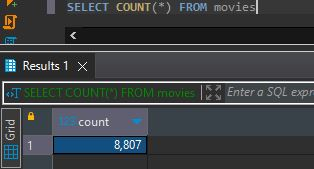

###Insertando Métodos de Pago

In [55]:
import data_payment_methods
methods = data_payment_methods.payment_method

#insertamos data en tabla de los payments
insertDataToSQL(methods, 'payment_methods')

Se han insertado 3 nuevos registros.


###Insertando las ventas de Marzo

Importamos el archivo que contiene las ventas de Marzo y la inertamos en la tabla ventas.

In [58]:
import data_ventas_march
marzo_ventas = data_ventas_march.ventas

#insertamos data en tabla de las ventas
insertDataToSQL(marzo_ventas, 'ventas')

Se han insertado 187 nuevos registros.
